# Data loading, cleaning and exploration

We start with adding packages that we need for the task of data exploration. 

In [1]:
!pip install pandas
!pip install .\pycld2-0.41-cp39-cp39-win_amd64.whl
!pip install langdetect
!pip install matplotlib
!pip install pywsd
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install tmtoolkit
!pip install gensim
!pip install pyLDAvis
!pip install seq2pat
!pip install prefixspan


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Processing c:\users\elina\documents\radboud\masters\research-internship\pycld2-0.41-cp39-cp39-win_amd64.whl
pycld2 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import os, sys
path = os.path.join(os.path.abspath(""), 'internship-env', 'Lib', 'site-packages')
sys.path.append(path)

import glob
import json
import string
import math
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.model_selection import train_test_split
import random

import langdetect
import pycld2 as cld2

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Set random seed to 42
random.seed(42)

import re
import shlex
import keyword

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Define stop words
stop_words = stopwords.words('english')

In [7]:
devgpt_location = "./DevGPT/"
github_devgpt_snapshot_folders = [path for path,_,_ in os.walk(devgpt_location) if "snapshot" in path]
commits_json_filepaths = []
issues_json_filepaths = []
discussion_json_filepaths = []
pull_requests_json_filepaths = []
code_json_filepaths = []
hackernews_json_filepaths = []
for snapshot_folder in github_devgpt_snapshot_folders:
    json_file_paths = glob.glob(f'{snapshot_folder}/*.json')
    for json_file_path in json_file_paths:
        if "commit" in json_file_path:
            commits_json_filepaths.append(json_file_path)
        elif "issue" in json_file_path:
            issues_json_filepaths.append(json_file_path)
        elif "discussion" in json_file_path:
            discussion_json_filepaths.append(json_file_path)
        elif "pr" in json_file_path:
            pull_requests_json_filepaths.append(json_file_path)
        elif "file" in json_file_path:
            code_json_filepaths.append(json_file_path)
        elif "hn" in json_file_path:
            hackernews_json_filepaths.append(json_file_path)
        else:
            raise Exception(f"JSON file '{json_file_paths}' was not recognised!")

""" Uncomment to print out all the file paths!
print(commits_json_filepaths)
print(issues_json_filepaths)
print(discussion_json_filepaths)
print(pull_requests_json_filepaths)
print(code_json_filepaths)
print(hackernews_json_filepaths)
"""

' Uncomment to print out all the file paths!\nprint(commits_json_filepaths)\nprint(issues_json_filepaths)\nprint(discussion_json_filepaths)\nprint(pull_requests_json_filepaths)\nprint(code_json_filepaths)\nprint(hackernews_json_filepaths)\n'

We start with looking closely at what data is contained in the files and whether newer snapshots were just appended with new information, but contain old snapshot information as well, or they just contain information that was created after the last snapshot was combined. 

In [8]:
# ========================= Columns =========================
commit_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message', 'AuthorAt', 'CommitAt']
code_file_columns = ['Type', 'URL', 'ObjectSha', 'FileName', 'FilePath', 'Author', 'Content', 'RepoName', 'RepoLanguage', 'CommitSha', 'CommitMessage', 'AuthorAt', 'CommitAt']
issue_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'State']
pull_request_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'CommitSha']
hacker_news_columns = ['Type', 'ID', 'URL', 'Author', 'Points', 'AttachedURL', 'Title', 'StoryText', 'CreatedAt', 'CommentsTotalCount']
discussion_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'Closed', 'UpvoteCount']
mention_columns = ['MentionedURL', 'MentionedProperty', 'MentionedAuthor', 'MentionedText', 'MentionedPath','MentionedAnswer', 'MentionedUpvoteCount']
gpt_sharing_columns = ['SharingURL', 'Status', 'DateOfConversation', 'DateOfAccess', 'NumberOfPrompts', 'TokensOfPrompts', 'TokensOfAnswers', 'Model', 'Conversations']

# ========================= Processing functions =========================
def process_commit_json(commit):
    commit_array_of_elements = [commit[col] for col in commit_columns]
    return commit_array_of_elements

def process_code_files_json(code_file):
    code_files_array_of_elements = [code_file[col] for col in code_file_columns]
    return code_files_array_of_elements

def process_issue_json(issue):
    issue_array_of_elements = [issue[col] if (col in issue) else "" for col in issue_columns]
    return issue_array_of_elements

def process_pull_request_json(pull_request):
    pull_request_array_of_elements = [pull_request[col] if (col in pull_request) else "" for col in pull_request_columns]
    return pull_request_array_of_elements

def process_hacker_news_json(hacker_news):
    hacker_news_array_of_elements = [hacker_news[col] for col in hacker_news_columns]
    return hacker_news_array_of_elements

def process_discussion_json(discussion):
    discussion_array_of_elements = [discussion[col] if (col in discussion) else "" for col in discussion_columns]
    return discussion_array_of_elements

def process_sharing_json(sharing):
    gptsharing_array_of_elements = [sharing['URL']]
    gptsharing_array_of_elements += [sharing[col] for col in gpt_sharing_columns[1:]]
    mention = sharing['Mention']
    gptsharing_array_of_elements += [mention[col] if (col in mention) else "" for col in mention_columns]
    return gptsharing_array_of_elements

In [9]:
def read_json_data_from_files_to_dataframe(filepaths_list):
    file_sharings_df = pd.DataFrame()
    for json_filepath in filepaths_list:
        with open(json_filepath, 'r') as file:
            # Load JSON data from file
            json_data = json.load(file)
            data_to_df = []
            for source in json_data['Sources']:
                source_array = []
                columns_for_df = []
                if source['Type'] == 'commit':
                    source_array = process_commit_json(source)
                    columns_for_df = commit_columns
                elif source['Type'] == 'code file':
                    source_array = process_code_files_json(source)
                    columns_for_df = code_file_columns
                elif source['Type'] == 'issue':
                    source_array = process_issue_json(source)
                    columns_for_df = issue_columns
                elif source['Type'] == 'pull request':
                    source_array = process_pull_request_json(source)
                    columns_for_df = pull_request_columns
                elif source['Type'] == 'hacker news':
                    source_array = process_hacker_news_json(source)
                    columns_for_df = hacker_news_columns
                elif source['Type'] == 'discussion':
                    source_array = process_discussion_json(source)
                    columns_for_df = discussion_columns
                else:
                    print(f"Unexpected type of the course: '{source['Type']}'")
                    raise
                for sharing in source['ChatgptSharing']:
                    if sharing['Status'] != 200:
                        continue
                    sharing_array = process_sharing_json(sharing)
                    data_to_df.append(source_array + sharing_array)
            file_dataframe = pd.DataFrame(data_to_df, columns=columns_for_df + gpt_sharing_columns + mention_columns)
            print(f"Data from '{json_filepath}' file contains {len(file_dataframe)} elements.")
            file_sharings_df = pd.concat([file_sharings_df, file_dataframe])
    print(f"When all the dataframes were concatenated/appended, we have total of {len(file_sharings_df)} rows in the DF.")
    file_sharings_df = file_sharings_df.drop_duplicates(subset=['SharingURL'], keep='last') # Keep newest
    print(f"After removing the duplicated based on ChatGPT URL of the source, we have total of {len(file_sharings_df)} rows in the DF.")
    return file_sharings_df

In [10]:
commits_dataframe = read_json_data_from_files_to_dataframe(commits_json_filepaths)
commits_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200003_commit_sharings.json' file contains 178 elements.
Data from './DevGPT/snapshot_20230803\20230803_095317_commit_sharings.json' file contains 214 elements.
Data from './DevGPT/snapshot_20230810\20230810_124807_commit_sharings.json' file contains 301 elements.
Data from './DevGPT/snapshot_20230817\20230817_131244_commit_sharings.json' file contains 198 elements.
Data from './DevGPT/snapshot_20230824\20230824_102435_commit_sharings.json' file contains 199 elements.
Data from './DevGPT/snapshot_20230831\20230831_063412_commit_sharings.json' file contains 477 elements.
Data from './DevGPT/snapshot_20230907\20230907_110036_commit_sharings.json' file contains 398 elements.
Data from './DevGPT/snapshot_20230914\20230914_083202_commit_sharings.json' file contains 568 elements.
Data from './DevGPT/snapshot_20230914\.ipynb_checkpoints\20230914_083202_commit_sharings-checkpoint.json' file contains 568 elements.
Data from './DevGPT/snapshot_20231

,Type,URL,Author,RepoName,RepoLanguage,Sha,Message,AuthorAt,CommitAt,SharingURL,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
7,commit,https://github.com/Hamza-Eng/baldie/commit/3a7...,Hamza-Eng,Hamza-Eng/baldie,Blade,3a7364f2ab5e67c80aa4f61f644f315e4b233390,add facebook pixel\n\nfor more information you...,2023-07-21T12:18:17.000+01:00,2023-07-21T12:18:17.000+01:00,https://chat.openai.com/share/e6c824b7-bf94-4b...,...,2097,,"[{'Prompt': 'add facebook pixel to laravel ', ...",https://github.com/Hamza-Eng/baldie/commit/3a7...,message,Hamza-Eng,add facebook pixel\n\nfor more information you...,,,
19,commit,https://github.com/jdustinwilliams/hibddbs/com...,dzdn,jdustinwilliams/hibddbs,CSS,e6a01ec078e950a277e7caa21affd7c4ae23d244,Make advanced search concise\n\nUsed ChatGPT f...,2023-08-22T14:09:17.000-04:00,2023-08-22T14:09:17.000-04:00,https://chat.openai.com/share/e476a2d0-5c29-4c...,...,1067,Default,[{'Prompt': 'Is there a way I could make this ...,https://github.com/jdustinwilliams/hibddbs/com...,message,dzdn,Make advanced search concise\n\nUsed ChatGPT f...,,,
0,commit,https://github.com/grnpin/textbox/commit/fa335...,grnpin,grnpin/textbox,HTML,fa335cf2ec447d00f8e94b54a8b463725b92947c,https://chat.openai.com/share/4bad57dd-9636-4b...,2023-09-20T21:02:53.000+09:00,2023-09-20T21:02:53.000+09:00,https://chat.openai.com/share/4bad57dd-9636-4b...,...,556,Default (GPT-3.5),[{'Prompt': 'このコードだと、スマートフォンでキーボードを表示したときにbutt...,https://github.com/grnpin/textbox/commit/fa335...,message,grnpin,https://chat.openai.com/share/4bad57dd-9636-4b...,,,
1,commit,https://github.com/grnpin/textbox/commit/0dfc4...,grnpin,grnpin/textbox,HTML,0dfc4385b723060e1e6a21da17a952bd908084ff,https://chat.openai.com/share/1fd7ffc2-9264-45...,2023-09-09T09:36:16.000+09:00,2023-09-09T09:36:16.000+09:00,https://chat.openai.com/share/1fd7ffc2-9264-45...,...,160,Default,[{'Prompt': 'このコードなんですが、Placeholder上でちゃんと改行するコ...,https://github.com/grnpin/textbox/commit/0dfc4...,message,grnpin,https://chat.openai.com/share/1fd7ffc2-9264-45...,,,
2,commit,https://github.com/grnpin/textbox/commit/811d0...,grnpin,grnpin/textbox,HTML,811d09acdca361c81281c7d71587ebdbd8437453,https://chat.openai.com/share/99d2d02f-7e3b-43...,2023-09-07T13:19:54.000Z,2023-09-07T13:19:54.000Z,https://chat.openai.com/share/99d2d02f-7e3b-43...,...,115,Default,[{'Prompt': 'refactor this code. <!DOCTYPE ht...,https://github.com/grnpin/textbox/commit/811d0...,message,grnpin,https://chat.openai.com/share/99d2d02f-7e3b-43...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,commit,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,HTML,d0a54935a6e665bfaaa858adb6afc42b231707fe,Add more stuff to look at. (#7)\n\nhttps://cha...,2023-07-03T11:52:29.000-07:00,2023-07-03T11:52:29.000-07:00,https://chat.openai.com/share/b53e39ef-0e39-40...,...,1429,GPT-4,[{'Prompt': 'ok the console errors are gone bu...,https://github.com/hoshotakamoto/banzukesurfin...,message,hoshotakamoto,Add more stuff to look at. (#7)\n\nhttps://cha...,,,
688,commit,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,HTML,90e1d68ddc8d3a2caa076ee4d423484bf0a742f3,Refactoring for interactivity. (#8)\n\nhttps:/...,2023-07-03T15:24:54.000-07:00,2023-07-03T15:24:54.000-07:00,https://chat.openai.com/share/76d4817d-40b6-4f...,...,2519,GPT-4,[{'Prompt': 'None of the localStorage stuff re...,https://github.com/hoshotakamoto/banzukesurfin...,message,hoshotakamoto,Refactoring for interactivity. (#8)\n\nhttps:/...,,,
689,commit,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,HTML,63b2ab90b0b138e509e87efad59fd72b414d0133,Incorporate local storage to put some state in...,2023-07-03T00:34:43.000-07:00,2023-07-03T00:34:43.000-07:00,https://chat.openai.com/share/b57df6eb-4eea-44...,...,3

In [11]:
issues_dataframe = read_json_data_from_files_to_dataframe(issues_json_filepaths)
issues_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195941_issue_sharings.json' file contains 243 elements.
Data from './DevGPT/snapshot_20230803\20230803_094705_issue_sharings.json' file contains 264 elements.
Data from './DevGPT/snapshot_20230810\20230810_123938_issue_sharings.json' file contains 306 elements.
Data from './DevGPT/snapshot_20230817\20230817_130502_issue_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20230824\20230824_101836_issue_sharings.json' file contains 369 elements.
Data from './DevGPT/snapshot_20230831\20230831_061759_issue_sharings.json' file contains 384 elements.
Data from './DevGPT/snapshot_20230907\20230907_092956_issue_sharings.json' file contains 419 elements.
Data from './DevGPT/snapshot_20230914\20230914_080417_issue_sharings.json' file contains 503 elements.
Data from './DevGPT/snapshot_20231012\20231012_235128_issue_sharings.json' file contains 598 elements.
When all the dataframes were concatenated/appended, we have total of 3416

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
11,issue,https://github.com/relaycorp/terraform-google-...,gnarea,relaycorp/terraform-google-awala-endpoint,HCL,4,Run bootstrapping job automatically every time...,See:\r\n\r\n- https://chat.openai.com/share/71...,,None,...,694,Default,[{'Prompt': 'I'm using Terraform to manage som...,https://github.com/relaycorp/terraform-google-...,body,gnarea,See:\r\n\r\n- https://chat.openai.com/share/71...,,,
157,issue,https://github.com/ookunirina/my_cinema_record...,ookunirina,ookunirina/my_cinema_record,Ruby,60,TMDb APIを使い投稿作成時のタイトル部分をオートコンプリートにする方法,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,None,...,1161,Default,[{'Prompt': '貴方は、Ruby on Railsでアプリ制作をする初心者エンジニ...,https://github.com/ookunirina/my_cinema_record...,body,ookunirina,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,,
119,issue,https://github.com/mostypc123/XediX/issues/6,mostypc123,mostypc123/XediX,Python,6,Firebase,How to connect Python to Firebase?,,2023-08-14T14:47:48Z,...,228,Default,[{'Prompt': 'Can I connect Firebase to my Pyth...,https://github.com/mostypc123/XediX/issues/6#i...,comments.body,mostypc123,"Completed, AI says me how to connect it. Chat:...",,,
29,issue,https://github.com/yeu-github/model/issues/1,yeu-github,yeu-github/model,None,1,melih,--,,None,...,3833,Default,[{'Prompt': 'euler acısını gorsellestiren bir ...,https://github.com/yeu-github/model/issues/1#i...,comments.body,yeu-github,https://chat.openai.com/share/0b1cd1fb-57e0-41...,,,
69,issue,https://github.com/CodeConnoisseur74/pdi-to-do...,bbelderbos,CodeConnoisseur74/pdi-to-do-list,Python,2,add a persistence layer,we can try sqlmodel (I will send you a customi...,,None,...,1996,Default,[{'Prompt': 'how to best explain sqlmodel to a...,https://github.com/CodeConnoisseur74/pdi-to-do...,comments.body,bbelderbos,@CodeConnoisseur74 I made this customized tuto...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,issue,https://github.com/ioccc-src/mkiocccentry/issu...,xexyl,ioccc-src/mkiocccentry,C,723,Question: Issues that aren’t really major issu...,Due to the fact that we have another issue tha...,,None,...,310,Default (GPT-3.5),[{'Prompt': 'Identify the quote: My precious. ...,https://github.com/ioccc-src/mkiocccentry/issu...,comments.body,xexyl,And as for the link to the other chat: https:/...,,,
594,issue,https://github.com/jasonacox/Powerwall-Dashboa...,aesculus,jasonacox/Powerwall-Dashboard,Python,288,Install On QNAP NAS with Graphana Port Change,I am making some progress on getting the dashb...,,2023-07-21T16:19:27Z,...,448,Default (GPT-3.5),[{'Prompt': 'Using docker compose I get the fo...,https://github.com/jasonacox/Powerwall-Dashboa...,comments.body,jasonacox,That's fantastic @aesculus ! Great progress.\...,,,
595,issue,https://github.com/MatrixAI/js-mdns/issues/1,joshuakarp,MatrixAI/js-mdns,TypeScript,1,Local Network Traversal - Multicast Discovery,_Created by @CMCDragonkai_ \r\n### Specificati...,,2023-07-24T07:37:55Z,...,6728,GPT-4,"[{'Prompt': 'In Linux, when you attach an ethe...",https://github.com/MatrixAI/js-mdns/issues/1#i...,comments.body,CMCDragonkai,Some relevant discussion about sockets and int...,,,
596,issue,https://github.com/open-spaced-repetition/fsrs...,L-M-Sherlock,open-spaced-repetition/fsrs4anki,Jupyter Notebook,351,[Doc] Introduction for FSRS v4,1) Re-writing the wiki. I suggest opening a ne...,,2023-09-20T15:56:42Z,...,1110,Plugins,"[{'Prompt': 'You are a professional explainer,...",https://github.com/open-spaced-repetition/fsrs...,comments.body,L-M-Sherlock,> These opinions and suggestions cover various...,,,


In [12]:
discussions_dataframe = read_json_data_from_files_to_dataframe(discussion_json_filepaths)
discussions_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195954_discussion_sharings.json' file contains 33 elements.
Data from './DevGPT/snapshot_20230803\20230803_094811_discussion_sharings.json' file contains 35 elements.
Data from './DevGPT/snapshot_20230810\20230810_124048_discussion_sharings.json' file contains 38 elements.
Data from './DevGPT/snapshot_20230817\20230817_130721_discussion_sharings.json' file contains 43 elements.
Data from './DevGPT/snapshot_20230824\20230824_102000_discussion_sharings.json' file contains 45 elements.
Data from './DevGPT/snapshot_20230831\20230831_061926_discussion_sharings.json' file contains 46 elements.
Data from './DevGPT/snapshot_20230907\20230907_093129_discussion_sharings.json' file contains 50 elements.
Data from './DevGPT/snapshot_20230914\20230914_080601_discussion_sharings.json' file contains 55 elements.
Data from './DevGPT/snapshot_20231012\20231012_235320_discussion_sharings.json' file contains 61 elements.
When all the dataframes were concaten

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,discussion,https://github.com/xihajun/Projects/discussions/3,xihajun,xihajun/Projects,Jupyter Notebook,3,ONNX model,学习ONNX： https://chat.openai.com/share/f868e43e...,,None,...,2204,Advanced Data Analysis,[{'Prompt': '什么是ONNX模型？我是一名新生，您是世界上最好的老师，也是最优秀...,https://github.com/xihajun/Projects/discussions/3,body,xihajun,学习ONNX： https://chat.openai.com/share/f868e43e...,,,
1,discussion,https://github.com/vueuse/vueuse/discussions/3355,bobmulder,vueuse/vueuse,TypeScript,3355,An utility method to trigger a function when s...,"Hi all,\r\n\r\nI have a usecase where I want t...",,None,...,428,Default (GPT-3.5),[{'Prompt': 'I have a vue 3 application. I hav...,https://github.com/vueuse/vueuse/discussions/3355,body,bobmulder,"Hi all,\r\n\r\nI have a usecase where I want t...",,,
2,discussion,https://github.com/huangyinhaow/blogGiscus/dis...,giscus,huangyinhaow/blogGiscus,None,11,屠呦呦：跨界者还是守界者？,# 屠呦呦：跨界者还是守界者？\n\n探讨屠呦呦：她是跨界者还是守界者？\n\nhttps:...,,None,...,1158,Default (GPT-3.5),[{'Prompt': '使以下文章更有逻辑性 屠呦呦究竟是跨界者还是守界者 时光如白驹...,https://github.com/huangyinhaow/blogGiscus/dis...,comments.body,huangyinhaow,https://chat.openai.com/share/9495ba64-83ce-41...,,,1
3,discussion,https://github.com/git-lfs/git-lfs/discussions...,ggrrll,git-lfs/git-lfs,Go,5457,documentation on reverting / untracking,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,None,...,533,Default (GPT-3.5),[{'Prompt': ' migrate back to git files tracke...,https://github.com/git-lfs/git-lfs/discussions...,body,ggrrll,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,,
4,discussion,https://github.com/prgrms-fe-devcourse/FEDC4_H...,jkea1,prgrms-fe-devcourse/FEDC4_HONKOK_JunilHwang,TypeScript,47,랜덤한 id 생성하기,id 생성을 라이브러리 사용을 안하고 커스텀 함수로 만든다고 들었던거 같은데 내일 ...,,None,...,281,Default (GPT-3.5),[{'Prompt': '자바스크립트로 랜덤한 id를 생성하는 함수 코드를 알려줘.'...,https://github.com/prgrms-fe-devcourse/FEDC4_H...,comments.body,jgjgill,gpt에 물어봤습니다..!\r\nhttps://chat.openai.com/shar...,,,1
5,discussion,https://github.com/orgs/community/discussions/...,eightnoteight,community/community,Ruby,62307,Copilot generating only one line at a time,### Select Topic Area\n\nQuestion\n\n### Body\...,,None,...,407,Default (GPT-3.5),[{'Prompt': 'generate missing code in the belo...,https://github.com/orgs/community/discussions/...,body,eightnoteight,### Select Topic Area\n\nQuestion\n\n### Body\...,,,
7,discussion,https://github.com/orgs/deep-foundation/discus...,FreePhoenix888,deep-foundation/Discussions,None,27,Should we worry about imports perfomance in ha...,My dialogue with chatgpt about it: https://cha...,,None,...,413,GPT-4,[{'Prompt': 'Can I always use await import ins...,https://github.com/orgs/deep-foundation/discus...,body,FreePhoenix888,My dialogue with chatgpt about it: https://cha...,,,
8,discussion,https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,JushBJJ,JushBJJ/Mr.-Ranedeer-AI-Tutor,None,74,v2.7 - Code Interpreter Exclusive,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,None,...,315,Advanced Data Analysis,"[{'Prompt': '=== Author: JushBJJ Name: ""Mr. Ra...",https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,body,JushBJJ,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,,
9,discussion,https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,JushBJJ,JushBJJ/Mr.-Ranedeer-AI-Tutor,None,74,v2.7 - Code Interpreter Exclusive,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,None,...,91,Default (GPT-3.5),[{'Prompt': '[Personalization Options] Lan...,https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,body,JushBJJ,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,,
10,discussion,https://github.com/clojure-emacs/cider/discuss...,vemv,clojure-emacs/cider,Emacs Lisp,3391,CiderGPT,"A clojure-specific ""gpt mode"" would seem nice ...",,None,...,122,GPT-4,[{'Prompt': 'Please assume the role of a Cloju...

In [13]:
pull_requests_dataframe = read_json_data_from_files_to_dataframe(pull_requests_json_filepaths)
pull_requests_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195927_pr_sharings.json' file contains 160 elements.
Data from './DevGPT/snapshot_20230727\.ipynb_checkpoints\20230727_195927_pr_sharings-checkpoint.json' file contains 160 elements.
Data from './DevGPT/snapshot_20230803\20230803_093947_pr_sharings.json' file contains 166 elements.
Data from './DevGPT/snapshot_20230810\20230810_123110_pr_sharings.json' file contains 175 elements.
Data from './DevGPT/snapshot_20230817\20230817_125147_pr_sharings.json' file contains 184 elements.
Data from './DevGPT/snapshot_20230824\20230824_100450_pr_sharings.json' file contains 197 elements.
Data from './DevGPT/snapshot_20230831\20230831_060603_pr_sharings.json' file contains 208 elements.
Data from './DevGPT/snapshot_20230907\20230907_091631_pr_sharings.json' file contains 220 elements.
Data from './DevGPT/snapshot_20230914\20230914_074826_pr_sharings.json' file contains 231 elements.
Data from './DevGPT/snapshot_20231012\20231012_233628_pr_sharings.json

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,CreatedAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
2,pull request,https://github.com/nestoca/actions/pull/29,felleg,nestoca/actions,Go,29,feat(devops-1790): create reusable action to p...,Questions left to answer:\r\n\r\n- To do my do...,2023-08-02T19:36:31Z,None,...,4455,,[{'Prompt': 'i want to create a github action ...,https://github.com/nestoca/actions/pull/29,body,felleg,Questions left to answer:\r\n\r\n- To do my do...,,,
91,pull request,https://github.com/nestoca/actions/pull/30,alexstojda,nestoca/actions,Go,30,feat(DEVOPS-1846): monorepo - Auto-promote PR ...,,2023-08-11T00:19:44Z,2023-08-15T21:04:38Z,...,416,Default,"[{'Prompt': 'In github actions, I have this co...",https://github.com/nestoca/actions/pull/30#dis...,reviews.body,silphid,Was wondering whether we could make this more ...,build-monorepo-app/action.yaml,,
67,pull request,https://github.com/n-koga96/practice-React-exa...,n-koga96,n-koga96/practice-React-example-1,JavaScript,1,練習ブランチ１,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,2023-06-09T05:02:58Z,2023-07-11T03:40:40Z,...,5415,Default,[{'Prompt': '自分のmac PCにnode.jsが入っているかどうかを確かめるコ...,https://github.com/n-koga96/practice-React-exa...,body,n-koga96,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,,,
106,pull request,https://github.com/zhyunk/zb-mission-store-res...,zhyunk,zhyunk/zb-mission-store-reserve,Java,54,"#29 service , controller 정리",this closes #29,2023-08-02T18:11:46Z,2023-08-02T18:11:54Z,...,553,Default,"[{'Prompt': 'java에서 단일 객체를 반환하는 최종 연산자', 'Answ...",https://github.com/zhyunk/zb-mission-store-res...,reviews.body,zhyunk,최종 연산자\r\nhttps://chat.openai.com/share/db0905...,mission/src/main/java/kim/zhyun/mission/seller...,,
131,pull request,https://github.com/ubiquity/ubiquity-dollar/pu...,ghost,ubiquity/ubiquity-dollar,None,724,add the cspell in husky,Resolves #562 \r\n,2023-07-08T19:11:22Z,2023-07-09T13:35:08Z,...,747,Default,[{'Prompt': 'I have an active codebase with a ...,https://github.com/ubiquity/ubiquity-dollar/pu...,comments.body,molecula451,> https://chat.openai.com/share/084a9c22-efea-...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,pull request,https://github.com/openai/evals/pull/1083,AaronGoldsmith,openai/evals,C++,1083,[Eval] Viewport to grid size,# Thank you for contributing an eval! ♥️\r\n\r...,2023-06-02T02:53:27Z,2023-07-04T02:05:57Z,...,2892,GPT-4,[{'Prompt': 'I'm having trouble understanding ...,https://github.com/openai/evals/pull/1083,body,AaronGoldsmith,# Thank you for contributing an eval! ♥️\r\n\r...,,,
282,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,qryxip,VOICEVOX/voicevox_core,C++,532,ドキュメントを刷新する,## 内容\r\n\r\nRust/C/Python APIのドキュメントを刷新します。\r...,2023-06-25T14:03:16Z,2023-08-02T11:22:43Z,...,615,GPT-4,[{'Prompt': 'こちらの変更に対して、 - /// 与えられたパスからモデ...,https://github.com/VOICEVOX/voicevox_core/pull...,reviews.body,Hiroshiba,ドラマとかでよく「被害者を解放しろ！」とか聞くのと、字面が「解き放つ」なのでまあ１０割の人に...,crates/voicevox_core/src/voice_model.rs,,
283,pull request,https://github.com/MatrixAI/Polykey/pull/552,CMCDragonkai,MatrixAI/Polykey,C++,552,Consolidating Configuration Entropy and Nodes ...,### Description\r\n\r\nThe configuration of Po...,2023-08-16T13:29:46Z,2023-10-04T06:03:18Z,...,286,GPT-4,[{'Prompt': 'Here is some rust code: ``` let ...,https://github.com/MatrixAI/Polykey/pull/552#i...,comments.body,CMCDragonkai,So simply because `maxIdleTimeout` has to be c...,,,
284,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,sevenc-nanashi,VOICEVOX/voicevox_core,C++,538,[vvm-async-api] Add: ユーザー辞書APIを追加,## 内容\r\n\r\nユーザー辞書を実装します。\r\n\r\n## 関連 Issue\...,2023-07-08T15:05:40Z,2023-07-22T14:01:36Z,...,319,Plugins,[{'Prompt': 'この2つの処理は一緒でしょうか？ const convertHa...,https://github.com/VOICEVOX/voicevox_core/pull...,reviews.body,Hiroshiba,ChatGPT君に違いを聞いてみたら

In [14]:
code_dataframe = read_json_data_from_files_to_dataframe(code_json_filepaths)
code_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200102_file_sharings.json' file contains 957 elements.
Data from './DevGPT/snapshot_20230803\20230803_103605_file_sharings.json' file contains 1052 elements.
Data from './DevGPT/snapshot_20230810\20230810_133121_file_sharings.json' file contains 1076 elements.
Data from './DevGPT/snapshot_20230817\20230817_151344_file_sharings.json' file contains 1047 elements.
Data from './DevGPT/snapshot_20230824\20230824_111114_file_sharings.json' file contains 1141 elements.
Data from './DevGPT/snapshot_20230831\20230831_072722_file_sharings.json' file contains 1306 elements.
Data from './DevGPT/snapshot_20230907\20230907_121304_file_sharings.json' file contains 1193 elements.
Data from './DevGPT/snapshot_20230914\20230914_104122_file_sharings.json' file contains 1184 elements.
Data from './DevGPT/snapshot_20231012\20231012_234250_file_sharings.json' file contains 2540 elements.
When all the dataframes were concatenated/appended, we have total of 11496

,Type,URL,ObjectSha,FileName,FilePath,Author,Content,RepoName,RepoLanguage,CommitSha,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
78,code file,https://github.com/howard9192/Promptgpt/blob/3...,1a115cfc7aec29606fb4149b7137f75d687ab40c,Instructions.md,Instructions.md,howard9192,IyBJbnN0YWxsYXRpb24gSW5zdHJ1Y3Rpb25zIPCfmoAKCl...,howard9192/Promptgpt,None,3bafe86771bead233aa8f968d944e45125693cce,...,351,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
79,code file,https://github.com/howard9192/Promptgpt/blob/3...,1a115cfc7aec29606fb4149b7137f75d687ab40c,Instructions.md,Instructions.md,howard9192,IyBJbnN0YWxsYXRpb24gSW5zdHJ1Y3Rpb25zIPCfmoAKCl...,howard9192/Promptgpt,None,3bafe86771bead233aa8f968d944e45125693cce,...,353,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
182,code file,https://github.com/mariolambrette/MResSW/blob/...,202d366b4c300a226c804935d8ff07dc48672ab1,YOLO_img_resize.R,emyolo/R/YOLO_img_resize.R,mariolambrette,IycgUmVzaXplIGFsbCBpbWFnZXMgaW4gYSBkaXJlY3Rvcn...,mariolambrette/MResSW,HTML,066479be09b9be7718137a395b091a1d44670bd6,...,567,Default,[{'Prompt': 'I have a large number of .jpg fil...,https://github.com/mariolambrette/MResSW/blob/...,code,mariolambrette,#' Resize all images in a directory\n#'\n#' Th...,,,
194,code file,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,211b38de6cb81ab3e24f72a953b507e920641d43,Resposta.txt,v2122-t2/src/main/kotlin/ex8/Resposta.txt,RicardoPinto26,VW1hIHJvb3QgcmVmZXJlbmNlIMOpIHVtYSBkYXMgcmVmZX...,RicardoPinto26/ISEL-LEIC-LAE-ALL_EXAM_SOLUTIONS,Java,03f1081077ff295b55532666b9207378f6daf667,...,411,Default,[{'Prompt': 'No contexto do Garbage Collector ...,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,code,RicardoPinto26,Uma root reference é uma das referencias base ...,,,
207,code file,https://github.com/baku67/ELAN_Projet_SquadFor...,021e85cb2be22bea567b56e48e845b1fc7b1acc9,tuto,Annexes/tuto,baku67,VE9ETyBkb3NzaXJ0CgpUcmVsbG8KTcOpdGhvZGUgTW9zb3...,baku67/ELAN_Projet_SquadForge,CSS,9a3e668e5f73d4974682989bed8d6b0d5f77f3f8,...,957,Default,[{'Prompt': 'Comment Facebook ou les autres ré...,https://github.com/baku67/ELAN_Projet_SquadFor...,code,baku67,TODO dossirt\n\nTrello\nMéthode Mosow (hierarc...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,code file,https://github.com/rumca-js/RSS-Link-Database-...,fa2dd24e0b9bd7f80327b45f0df9cbf17def47c9,https.hnrss.orgfrontpage_entries.md,2023/09/2023-09-09/https.hnrss.orgfrontpage_en...,rumca-js,IyBTb3VyY2U6SGFja2VyIE5ld3MgLSBmcm9udHBhZ2UsIF...,rumca-js/RSS-Link-Database-2023,HTML,0757d06e84d8c8c4adf97a2c73b384baf0b511be,...,394,GPT-4,[{'Prompt': 'Why doesn't Apple add cellular se...,https://github.com/rumca-js/RSS-Link-Database-...,code,rumca-js,"# Source:Hacker News - frontpage, URL:https://...",,,
2536,code file,https://github.com/theparticleman/theparticlem...,f3e7ef06a0f5238cb19de7983fa2c71bb3b317ba,can-chatgpt-do-test-driven-development.md,posts/can-chatgpt-do-test-driven-development.md,theparticleman,QSBmcmllbmQgb2YgbWluZSByZWNlbnRseSBwaW5nZWQgbW...,theparticleman/theparticleman.github.io,C#,69c4c61a61729c0ec73108f3e59e98623612539d,...,8781,Default (GPT-3.5),[{'Prompt': 'write code that converts arabic n...,https://github.com/theparticleman/theparticlem...,code,theparticleman,A friend of mine recently pinged me on LinkedI...,,,
2537,code file,https://github.com/thku8507/thku8507.github.io...,f6fb60acabee215263c83b55cf487384db789959,01-modis-ndvi.ipynb,Notebooks/01-modis-ndvi.ipynb,thku8507,ewogImNlbGxzIjogWwogIHsKICAgImNlbGxfdHlwZSI6IC...,thku8507/thku8507.github.io,HTML,d85f414af3435df66c9d7e5429bbcfd0ea1a83fa,...,560,Default

In [15]:
hackernews_dataframe = read_json_data_from_files_to_dataframe(hackernews_json_filepaths)
hackernews_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195816_hn_sharings.json' file contains 174 elements.
Data from './DevGPT/snapshot_20230803\20230803_105332_hn_sharings.json' file contains 191 elements.
Data from './DevGPT/snapshot_20230810\20230810_134011_hn_sharings.json' file contains 241 elements.
Data from './DevGPT/snapshot_20230817\20230817_170022_hn_sharings.json' file contains 267 elements.
Data from './DevGPT/snapshot_20230824\20230824_112153_hn_sharings.json' file contains 288 elements.
Data from './DevGPT/snapshot_20230831\20230831_073827_hn_sharings.json' file contains 293 elements.
Data from './DevGPT/snapshot_20230907\20230907_123434_hn_sharings.json' file contains 307 elements.
Data from './DevGPT/snapshot_20230914\20230914_105439_hn_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20231012\20231012_232232_hn_sharings.json' file contains 283 elements.
When all the dataframes were concatenated/appended, we have total of 2374 rows in the DF.
After remo

,Type,ID,URL,Author,Points,AttachedURL,Title,StoryText,CreatedAt,CommentsTotalCount,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,hacker news,37500887,https://news.ycombinator.com/item?id=37500887,gorenb,2.0,https://chat.openai.com/share/a7395106-b14e-47...,The Rust Evangelism Strike Force and Q-Anon: A...,None,2023-09-13T19:48:07.000Z,0,...,2915,Default,[{'Prompt': 'your feather tastes like a numeri...,https://news.ycombinator.com/item?id=37500887,url,gorenb,https://chat.openai.com/share/a7395106-b14e-47...,,,
1,hacker news,37494620,https://news.ycombinator.com/item?id=37494620,JonathanFly,336.0,https://stability.ai/research/stable-audio-eff...,Stable Audio: Fast Timing-Conditioned Latent A...,None,2023-09-13T10:00:00.000Z,28,...,120,Default,[{'Prompt': 'Show me 12 bars of chords for blu...,https://news.ycombinator.com/item?id=37497106,comment,viraptor,From what I've seen in the generated tracks so...,,,
2,hacker news,37480155,https://news.ycombinator.com/item?id=37480155,arbesman,167.0,https://resobscura.substack.com/p/simulating-h...,Simulating History with ChatGPT,None,2023-09-12T12:34:40.000Z,15,...,1194,Default,[{'Prompt': 'Step into 🏯HISTORYLENS: Russian R...,https://news.ycombinator.com/item?id=37490574,comment,rastapasta42,What are your thoughts on this update? <a href...,,,
3,hacker news,37480155,https://news.ycombinator.com/item?id=37480155,arbesman,167.0,https://resobscura.substack.com/p/simulating-h...,Simulating History with ChatGPT,None,2023-09-12T12:34:40.000Z,15,...,508,Default,[{'Prompt': '==== Text extracted from the Min...,https://news.ycombinator.com/item?id=37486524,comment,DonHopkins,Great idea!<p>Why leave hallucinations to chan...,,,
4,hacker news,37480155,https://news.ycombinator.com/item?id=37480155,arbesman,167.0,https://resobscura.substack.com/p/simulating-h...,Simulating History with ChatGPT,None,2023-09-12T12:34:40.000Z,15,...,502,Default,[{'Prompt': 'Please become 🏯HISTORYLENS: MING ...,https://news.ycombinator.com/item?id=37483815,comment,benbreen,"""I think it can be taken further; rather than ...",,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,860,GPT-4,[{'Prompt': 'You were advised the following to...,https://news.ycombinator.com/item?id=36091952,comment,BoorishBears,How imaginative do you consider this story: <a...,,,
279,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,323,GPT-4,[{'Prompt': 'Let's work this out in a step-by-...,https://news.ycombinator.com/item?id=36091686,comment,e1g,Seems to do fine if you instruct it to get to ...,,,
280,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,153,Web Browsing,[{'Prompt': 'Who is Obie Fernandez and what is...,https://news.ycombinator.com/item?id=36091476,comment,obiefernandez,"Vanity search in 2023 <a href=""https://chat.op...",,,
281,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,392,GPT-4,"[{'Prompt': 'What is Hacker News, what can you...",https://news.ycombinator.com/item?id=36091388,url,obiefernandez,https://chat.openai.com/share/66169853-d00a-4b...,,,


In [16]:
java_kw = ['abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char', 'class', 'continue', 'default', 'do', 'double', 
                 'else', 'enum', 'extends', 'final', 'finally', 'float', 'for', 'if', 'implements', 'import', 'instanceof', 'int', 'interface', 
                 'long', 'native', 'new', 'null', 'package', 'private', 'protected', 'public', 'return', 'short', 'static', 'strictfp', 'super', 
                 'switch', 'synchronized', 'this', 'throw', 'throws', 'transient', 'try', 'void', 'volatile', 'while']
typeless_c_kw = ['auto', 'break', 'const', 'continue', 'do', 'else', 'enum', 'extern', 'for', 'goto', 'if', 'lambda', 'register', 'return', 'sizeof', 
              'static', 'struct', 'typedef', 'union', 'void', 'volatile', 'while']
html_tags = ['<div', '<div>', '</div>', '<p', '<p>', '</p>', '<a', '<a>', '</a>', '<img>', '<img', '<ul>', '<li>', '</li>', '</ul>', '<ol>', '</ol>',
            '<table>', '</table>', '<tr>', '</tr>', '<th>', '</th>', '<td>', '</td>', '<form', '</form>', '<input', '<button>', '</button>', 
            '<h1>', '<h2>', '<h3>', '<h4>', '<h5>', '<h6>', '</h1>', '</h2>', '</h3>', '</h4>', '</h5>', '</h6>', '<span>', '</span>', '<label>', 
             '<label', '</label>', '<iframe>', '<iframe' '</iframe>']
css_references = ['accent-color', 'align-content', 'align-items', 'align-self', 'all', 'animation', 'animation-delay', 'animation-direction', 'animation-duration', 'animation-fill-mode', 'animation-iteration-count', 'animation-name', 'animation-play-state', 'animation-timing-function', 'aspect-ratio', 'backdrop-filter', 'backface-visibility', 'background', 'background-attachment', 'background-blend-mode', 'background-clip', 'background-color', 'background-image', 'background-origin', 'background-position', 'background-position-x', 'background-position-y', 'background-repeat', 'background-size', 'block-size', 'border', 'border-block', 'border-block-color', 'border-block-end', 'border-block-end-color', 'border-block-end-style', 'border-block-end-width', 'border-block-start', 'border-block-start-color', 'border-block-start-style', 'border-block-start-width', 'border-block-style', 'border-block-width', 'border-bottom', 'border-bottom-color', 'border-bottom-left-radius', 'border-bottom-right-radius', 'border-bottom-style', 'border-bottom-width', 'border-collapse', 'border-color', 'border-end-end-radius', 'border-end-start-radius', 'border-image', 'border-image-outset', 'border-image-repeat', 'border-image-slice', 'border-image-source', 'border-image-width', 'border-inline', 'border-inline-color', 'border-inline-end', 'border-inline-end-color', 'border-inline-end-style', 'border-inline-end-width', 'border-inline-start', 'border-inline-start-color', 'border-inline-start-style', 'border-inline-start-width', 'border-inline-style', 'border-inline-width', 'border-left', 'border-left-color', 'border-left-style', 'border-left-width', 'border-radius', 'border-right', 'border-right-color', 'border-right-style', 'border-right-width', 'border-spacing', 'border-start-end-radius', 'border-start-start-radius', 'border-style', 'border-top', 'border-top-color', 'border-top-left-radius', 'border-top-right-radius', 'border-top-style', 'border-top-width', 'border-width', 'bottom', 'box-decoration-break', 'box-reflect', 'box-shadow', 'box-sizing', 'break-after', 'break-before', 'break-inside', 'caption-side', 'caret-color', '@charset', 'clear', 'clip', 'clip-path', 'color', 'column-count', 'column-fill', 'column-gap', 'column-rule', 'column-rule-color', 'column-rule-style', 'column-rule-width', 'column-span', 'column-width', 'columns', 'content', 'counter-increment', 'counter-reset', 'counter-set', 'cursor', 'direction', 'display', 'empty-cells', 'filter', 'flex', 'flex-basis', 'flex-direction', 'flex-flow', 'flex-grow', 'flex-shrink', 'flex-wrap', 'float', 'font', '@font-face', 'font-family', 'font-feature-settings', 'font-kerning', 'font-size', 'font-size-adjust', 'font-stretch', 'font-style', 'font-variant', 'font-variant-caps', 'font-weight', 'gap', 'grid', 'grid-area', 'grid-auto-columns', 'grid-auto-flow', 'grid-auto-rows', 'grid-column', 'grid-column-end', 'grid-column-gap', 'grid-column-start', 'grid-gap', 'grid-row', 'grid-row-end', 'grid-row-gap', 'grid-row-start', 'grid-template', 'grid-template-areas', 'grid-template-columns', 'grid-template-rows', 'hanging-punctuation', 'height', 'hyphens', 'hyphenate-character', 'image-rendering', '@import', 'inline-size', 'inset', 'inset-block', 'inset-block-end', 'inset-block-start', 'inset-inline', 'inset-inline-end', 'inset-inline-start', 'isolation', 'justify-content', 'justify-items', 'justify-self', '@keyframes', 'left', 'letter-spacing', 'line-height', 'list-style', 'list-style-image', 'list-style-position', 'list-style-type', 'margin', 'margin-block', 'margin-block-end', 'margin-block-start', 'margin-bottom', 'margin-inline', 'margin-inline-end', 'margin-inline-start', 'margin-left', 'margin-right', 'margin-top', 'mask-image', 'mask-mode', 'mask-origin', 'mask-position', 'mask-repeat', 'mask-size', 'max-block-size', 'max-height', 'max-inline-size', 'max-width', '@media', 'min-block-size', 'min-inline-size', 'min-height', 'min-width', 'mix-blend-mode', 'object-fit', 'object-position', 'offset', 'offset-anchor', 'offset-distance', 'offset-path', 'offset-rotate', 'opacity', 'order', 'orphans', 'outline', 'outline-color', 'outline-offset', 'outline-style', 'outline-width', 'overflow', 'overflow-anchor', 'overflow-wrap', 'overflow-x', 'overflow-y', 'overscroll-behavior', 'overscroll-behavior-block', 'overscroll-behavior-inline', 'overscroll-behavior-x', 'overscroll-behavior-y', 'padding', 'padding-block', 'padding-block-end', 'padding-block-start', 'padding-bottom', 'padding-inline', 'padding-inline-end', 'padding-inline-start', 'padding-left', 'padding-right', 'padding-top', 'page-break-after', 'page-break-before', 'page-break-inside', 'paint-order', 'perspective', 'perspective-origin', 'place-content', 'place-items', 'place-self', 'pointer-events', 'position', 'quotes', 'resize', 'right', 'rotate', 'row-gap', 'scale', 'scroll-behavior', 'scroll-margin', 'scroll-margin-block', 'scroll-margin-block-end', 'scroll-margin-block-start', 'scroll-margin-bottom', 'scroll-margin-inline', 'scroll-margin-inline-end', 'scroll-margin-inline-start', 'scroll-margin-left', 'scroll-margin-right', 'scroll-margin-top', 'scroll-padding', 'scroll-padding-block', 'scroll-padding-block-end', 'scroll-padding-block-start', 'scroll-padding-bottom', 'scroll-padding-inline', 'scroll-padding-inline-end', 'scroll-padding-inline-start', 'scroll-padding-left', 'scroll-padding-right', 'scroll-padding-top', 'scroll-snap-align', 'scroll-snap-stop', 'scroll-snap-type', 'scrollbar-color', 'tab-size', 'table-layout', 'text-align', 'text-align-last', 'text-decoration', 'text-decoration-color', 'text-decoration-line', 'text-decoration-style', 'text-decoration-thickness', 'text-emphasis', 'text-emphasis-color', 'text-emphasis-position', 'text-emphasis-style', 'text-indent', 'text-justify', 'text-orientation', 'text-overflow', 'text-shadow', 'text-transform', 'text-underline-offset', 'text-underline-position', 'top', 'transform', 'transform-origin', 'transform-style', 'transition', 'transition-delay', 'transition-duration', 'transition-property', 'transition-timing-function', 'translate', 'unicode-bidi', 'user-select', 'vertical-align', 'visibility', 'white-space', 'widows', 'width', 'word-break', 'word-spacing', 'word-wrap', 'writing-mode', 'z-index']
cmd_kw = ['active', 'add', 'alias', 'volume', 'adprep', 'append', 'arp', 'assign', 'assoc', 'at', 'atmadm', 'attach-vdisk', 'attrib', 'attributes', 'auditpol', 'autochk', 'autoconv', 'autofmt', 'automount', 'bcdboot', 'bcdedit', 'bdehdcfg', 'bitsadmi', 'bootcfg', 'cacls', 'call', 'cd', 'certreq', 'certutil', 'change', 'chcp', 'chdir', 'chglogon', 'chgport', 'chgusr', 'chkdsk', 'chkntfs', 'choice', 'cipher', 'clean', 'cleanmgr', 'cls', 'cmd', 'cmdkey', 'cmstp', 'comp', 'compact', 'convert', 'copy', 'create', 'cscript', 'date', 'dcdiag', 'dcgpofix', 'dcpromo', 'defrag', 'del', 'delete', 'detail', 'dfsdiag', 'dfsrmig', 'diantz', 'dir', 'diskcomp', 'diskcopy', 'diskpart', 'diskperf', 'diskraid', 'diskshadow', 'dispdiag', 'dnscmd', 'doskey', 'driverquery', 'dtrace', 'echo', 'edit', 'endlocal', 'end', 'restore', 'erase', 'eventcreate', 'Evntcmd', 'exec', 'exit', 'expand', 'expose', 'extend', 'extract', 'fc', 'filesystems', 'find', 'findstr', 'finger', 'flattemp', 'fondue', 'forfiles', 'format', 'freedisk', 'fsutil', 'ftp', 'ftype', 'fveupdate', 'getmac', 'gettype', 'gpfixup', 'gpresult', 'gpt', 'gpupdate', 'graftabl', 'help', 'helpctr', 'hostname', 'icacls', 'inactive', 'ipconfig', 'ipxroute', 'irftp', 'jetpack', 'klist', 'ksetup', 'ktmutil', 'ktpass', 'label', 'list', 'lodctr', 'logman', 'logoff', 'lpq', 'lpr', 'macfile', 'makecab', 'manage', 'bde', 'mapadmin', 'md', 'merge', 'vdisk', 'mkdir', 'mklink', 'mmc', 'mode', 'more', 'mount', 'mountvol', 'move', 'mqbkup', 'mqsvc', 'mqtgsvc', 'msdt', 'msg', 'msiexec', 'msinfo32', 'mstsc', 'nbtstat', 'netcfg', 'netdom', 'net', 'print', 'netsh', 'netstat', 'nfsadmin', 'nfsshare', 'nfsstat', 'nlbmgr', 'nltest', 'nslookup', 'ntbackup', 'ntcmdprompt', 'ntfrsutl', 'offline', 'online', 'openfiles', 'pagefileconfig', 'path', 'pathping', 'pause', 'pbadmin', 'pentnt', 'perfmon', 'ping', 'pktmon', 'pnpunattend', 'pnputil', 'popd', 'powershell', 'prncnfg', 'prndrvr', 'prnjobs', 'prnmngr', 'prnport', 'prnqctl', 'prompt', 'pubprn', 'pushd', 'pushprinterconnections', 'pwlauncher', 'pwsh', 'qappsrv', 'qprocess', 'query', 'quser', 'qwinsta', 'rd', 'rdpsign', 'recover', 'refsutil', 'reg', 'regini', 'regsvr32', 'relog', 'rem', 'remove', 'ren', 'rename', 'repadmin', 'repair', 'replace', 'rescan', 'reset', 'retain', 'revert', 'rexec', 'risetup', 'rmdir', 'robocopy', 'route', 'rpcinfo', 'rpcping', 'rsh', 'rundll32', 'rwinsta', 'san', 'sc', 'schtasks', 'scwcmd', 'secedit', 'select', 'serverceipoptin', 'servermanagercmd', 'serverweroptin', 'set', 'setlocal', 'metadata', 'option', 'verbose', 'setx', 'sfc', 'shadow', 'shift', 'showmount', 'shrink', 'shutdown', 'simulate', 'sort', 'start', 'subcommand', 'subst', 'sxstrace', 'sysocmgr', 'systeminfo', 'takeown', 'tapicfg', 'taskkill', 'tasklist', 'tcmsetup', 'telnet', 'tftp', 'time', 'timeout', 'title', 'tlntadmn', 'tpmtool', 'tpmvscmgr', 'tracerpt', 'tracert', 'tree', 'tscon', 'tsdiscon', 'tsecimp', 'tskill', 'tsprof', 'type', 'typeperf', 'tzutil', 'unexpose', 'uniqueid', 'unlodctr', 'ver', 'verifier', 'verify', 'vol', 'vssadmin', 'waitfor', 'wbadmin', 'wdsutil', 'wecutil', 'wevtutil', 'where', 'whoami', 'winnt', 'winnt32', 'winrs', 'winsat', 'mem', 'mfmedia', 'wmic', 'writer', 'wscript', 'xcopy']
linux_kw = ['apropos', 'apt', 'apt-get', 'aptitude', 'aspell', 'awk', 'basename', 'base32', 'base64', 'bash', 'bc', 'bg', 'bind', 'builtin', 'bzip2', 'cal', 'caller', 'cat', 'cfdisk', 'chattr', 'chgrp', 'chmod', 'chown', 'chpasswd', 'chroot', 'chkconfig', 'cksum', 'clear_console', 'cmp', 'comm', 'command', 'cp', 'cpio', 'cron', 'crontab', 'csplit', 'curl', 'cut', 'dc', 'dd', 'ddrescue', 'declare', 'df', 'diff', 'diff3', 'dig', 'dircolors', 'dirname', 'dirs', 'dos2unix', 'dmesg', 'dpkg', 'du', 'egrep', 'eject', 'enable', 'env', 'ethtool', 'eval', 'export', 'expr', 'false', 'fdformat', 'fdisk', 'fg', 'fgrep', 'file', 'fmt', 'fold', 'free', 'fsck', 'function', 'fuser', 'gawk', 'getopts', 'getfacl', 'grep', 'groupadd', 'groupdel', 'groupmod', 'groups', 'gzip', 'hash', 'head', 'history', 'htop', 'iconv', 'id', 'ifconfig', 'ifdown', 'ifup', 'install', 'iostat', 'ip', 'jobs', 'join', 'kill', 'killall', 'less', 'let', 'link', 'ln', 'local', 'locate', 'logname', 'logout', 'look', 'lpc', 'lprint', 'lprintd', 'lprintq', 'lprm', 'lsattr', 'lsblk', 'ls', 'lsof', 'lspci', 'make', 'man', 'mapfile', 'md5sum', 'mkfifo', 'mkfile', 'mkisofs', 'mknod', 'mktemp', 'most', 'mtools', 'mtr', 'mv', 'mmv', 'nc', 'nft', 'nice', 'nl', 'nohup', 'notify-send', 'open', 'op', 'passwd', 'paste', 'pathchk', 'Perf', 'pgrep', 'pkill', 'pr', 'printcap', 'printenv', 'printf', 'ps', 'pv', 'pwd', 'quota', 'quotacheck', 'ram', 'rar', 'rcp', 'read', 'readarray', 'readonly', 'reboot', 'renice', 'remsync', 'rev', 'rm', 'rsync', 'screen', 'scp', 'sdiff', 'sed', 'seq', 'setfacl', 'sftp', 'sha256sum', 'shopt', 'shuf', 'sleep', 'slocate', 'source', 'split', 'ss', 'ssh', 'stat', 'strace', 'su', 'sudo', 'sum', 'suspend', 'sync', 'tabs', 'tail', 'tar', 'tee', 'test', 'times', 'tmux', 'touch', 'tput', 'traceroute', 'trap', 'tr', 'true', 'tsort', 'tty', 'ulimit', 'umask', 'umount', 'unalias', 'uname', 'unexpand', 'uniq', 'units', 'unix2dos', 'unrar', 'unset', 'unshar', 'until', 'uptime', 'useradd', 'userdel', 'usermod', 'users', 'uuencode', 'uudecode', 'vdir', 'vi', 'vmstat', 'w', 'wait', 'watch', 'wc', 'whereis', 'which', 'who', 'wget', 'write', 'xargs', 'xdg-open', 'xxd', 'xz', 'yes', 'zip']
error_kw = ['File', 'Traceback', "line", "Error", "ERROR", ]

def detect_programming_languages(line, detect_language = False):
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]
    if '"' in line:
        try:
            words = shlex.split(line)
        except:
            words = line.split(" ")
    else:
        words = line.split(" ")
    if len(words) == 0:
        return ("prog", "prog")
    words_normal_language_probability = []
    if line.strip().startswith(("//",  "/*", "--", "\"\"\"", "#", "<!--")) or line.strip().endswith(("*/", "\"\"\"", "-->")):
        words_normal_language_probability.append(0)
    if re.search('<.*?>(.*?)<\/.*?>', line.strip()) != None:
        words_normal_language_probability.append(0)
    if len(words_normal_language_probability) != 1:
        for word in words:
            if " " in word: # The word is actually the sentence within brackets that was split using shlex
                sentence = word.split(" ")
                sentence_prob = 0
                for w in sentence:
                    word_prog_prob = detect_programming_languages(w)
                    if word_prog_prob == ("not_prog", "not_prog"):
                        sentence_prob += 1
                    elif word_prog_prob == ("not_prog", "not_prog"):
                        sentence_prob += 0
                words_normal_language_probability.append(sentence_prob/len(sentence))
            elif word.startswith("\t"):
                words_normal_language_probability.append(0)
            elif word in keyword.kwlist or word in java_kw or word in typeless_c_kw or \
                word in html_tags or word in css_references or word in cmd_kw or word in linux_kw or word in error_kw:
                    words_normal_language_probability.append(0.5)
            # Error message names: e.g. StackOverflow, ZeroDivisionError, etc.
            elif word != word.lower() and word != word.upper() and "_" not in word and sum(i.isupper() for i in word[1:-1]) >= 1:
                words_normal_language_probability.append(0)
            elif word.isupper(): # Also covers SQL keywords
                words_normal_language_probability.append(0.5)
            elif word.isalpha():
                words_normal_language_probability.append(1)
            # ; is not added, because it is commonly used in programming languages, and less in natural speech
            elif re.search('\w+[,|.|?|!|:]', word) != None: 
                words_normal_language_probability.append(0.5)
            elif re.search('[a-zA-Z]', word) == None or word == "":
                words_normal_language_probability.append(0)
            elif re.search('[::|::-|:|#|@|.|<\\|<]\w+', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('<\w+>', word) != None or re.search('<\\\w+>', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('[a-zA-Z]+\([^\)]*\)(\.[^\)]*\))?', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('\w+\.\w+', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('\[\w+\]', word) != None:
                words_normal_language_probability.append(0)
            else:
                words_normal_language_probability.append(1)
    likely_natural_language = sum(words_normal_language_probability)/len(words_normal_language_probability)
    if likely_natural_language > 0.5:
        if detect_language == True:
            languages_2tuple = ("", "")
            reliable = False
            try:
                isReliable, textBytesFound, details = cld2.detect(line)
                langdetect_lang = langdetect.detect(line)
                cld2_lang = details[0][1]
                reliable = isReliable
                languages_2tuple = (langdetect_lang, cld2_lang)
            except:
                print(f"Language was not identified for prompt: {line}")
                return ('un', 'un')
            return languages_2tuple
        else:
            return ("not_prog", "not_prog")
    else:
        return ("prog", "prog")

In [18]:
dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

for idx, dataframe in enumerate(dataframes):
    print(f"Dataframe {dataframe_names[idx]} elements before language check: {len(dataframe)}")
    for index, df_row in dataframe.iterrows():
        conversations = df_row["Conversations"]
        list_of_languages = []
        for conv in conversations:
            for line in conv['Prompt'].split("\n"):
                language = detect_programming_languages(line, True)
                if language == ("prog", "prog"):
                    continue
                else:
                    list_of_languages.append(language)
        if len(list_of_languages) > 0:
            most_common = max(set(list_of_languages), key = list_of_languages.count)
        else:
            most_common = ('un', 'un')
        if not (most_common == ('en', 'en') or most_common == ('un', 'en') or most_common == ('en', 'un')):
            dataframe.drop(index, inplace=True)
    print(f"Dataframe elements after language check: {len(dataframe)}")
    print("======================================================================================")

Dataframe commits elements before language check: 661
Language was not identified for prompt: Done: Rename and refactor SVG to PNG converter
Dataframe elements after language check: 661
Dataframe issues elements before language check: 436
Language was not identified for prompt: Label Smoothing During training, we employed label smoothing of value ls = 0.1 [30]. This
Language was not identified for prompt: N dmodel dff h dk dv Pdrop ls
Dataframe elements after language check: 432
Dataframe discussions elements before language check: 52
Language was not identified for prompt: The command "PATH=$PATH:/usr/local/bin:/opt/homebrew/bin NODE_PATH=`npm root -g` node '/home/forge/dev1.rrdevours.monster/vendor/spatie/browsershot/src/../bin/browser.js' '{"url":"https:\/\/www.google.com\/","action":"screenshot","options":{"type":"png","path":"example.png","args":[],"viewport":{"width":800,"height":600}}}'" failed. Exit Code: 1(General error) Working directory: /home/forge/dev1.rrdevours.monster/

# Check how well programming language detection works

In [22]:
programming_language_detector_filename = "./programming_language_detector_check.json"

In [25]:
# Switch this variable to 'True' in order to generate the new file
check_language_detection = False

if check_language_detection:
    dataset_line_language_list = {}
    for idx, dataframe in enumerate(dataframes):
        rand_list = []
        for i in range(5): # We want to check 5 conversations per dataset
            rand_n = random.randint(0, len(dataframe))
            while rand_n in rand_list:
                rand_n = random.randint(0, len(dataframe))
            rand_list.append(rand_n)
        line_language_list = []
        for index, df_row in dataframe.iterrows():
            if not index in rand_list:
                continue
            conversations = df_row["Conversations"]
            list_of_languages = []
            for conv in enumerate(conversations):
                list_of_lines = conv[1]['Prompt'].split("\n")
                nr_of_lines = 20
                random_conv_lines = []
                if 2*nr_of_lines <= len(list_of_lines):
                    for i in range(nr_of_lines):
                        rand_line_nr = random.randint(0, len(list_of_lines)-1)
                        while rand_line_nr in random_conv_lines or len(list_of_lines[rand_line_nr]) == 0:
                            rand_line_nr = random.randint(0, len(list_of_lines)-1)
                        random_conv_lines.append(rand_line_nr)
                else: 
                    random_conv_lines = [item for item in range(min(nr_of_lines, len(list_of_lines)))]
                for line_nr in random_conv_lines:
                    language = detect_programming_languages(list_of_lines[line_nr])
                    line_language_list.append({"Line": list_of_lines[line_nr], "Language": language, "is_program": False})
        dataset_line_language_list[dataframe_names[idx]] = line_language_list
    
    with open(programming_language_detector_filename, 'w') as file:
        json.dump(dataset_line_language_list, file)

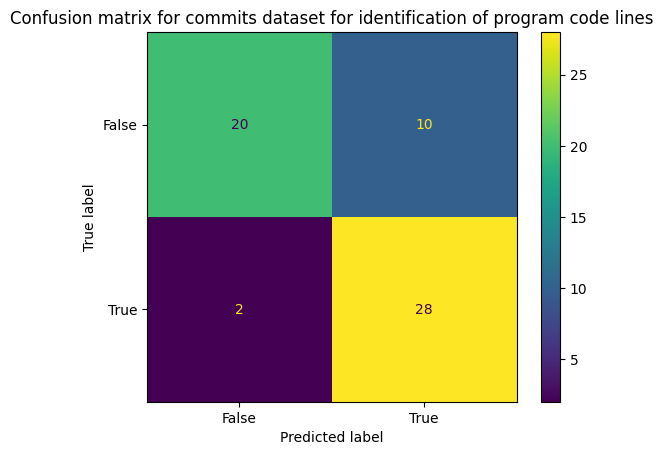

Accuracy score: 0.8


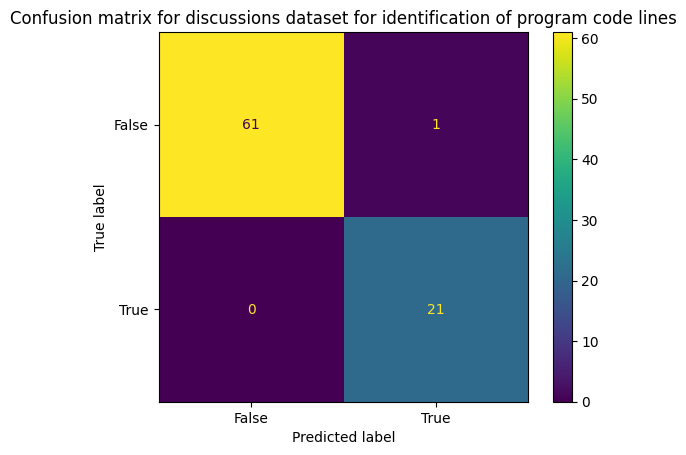

Accuracy score: 0.9879518072289156


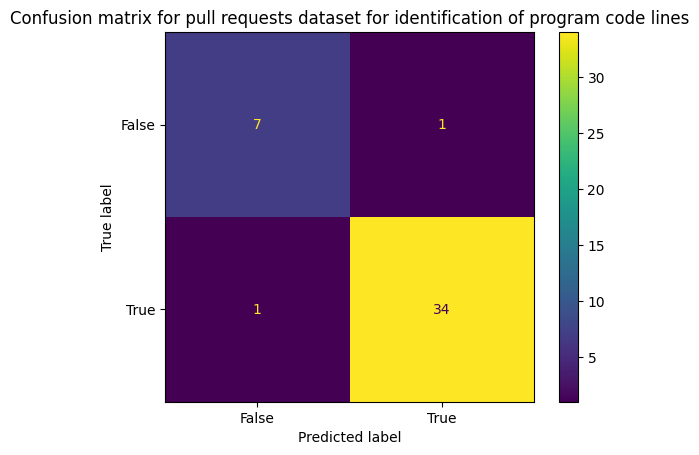

Accuracy score: 0.9534883720930233


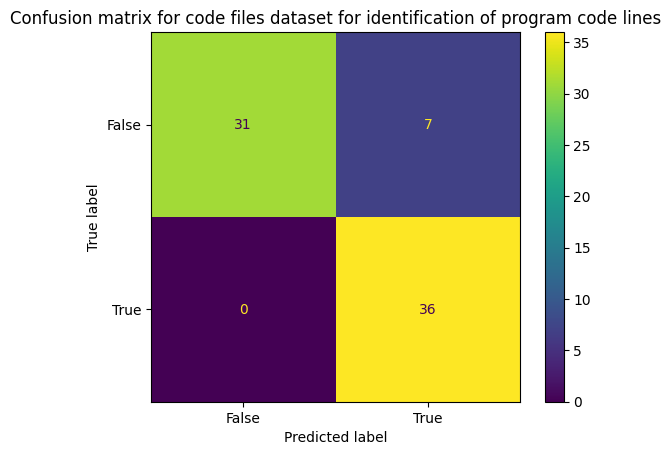

Accuracy score: 0.9054054054054054


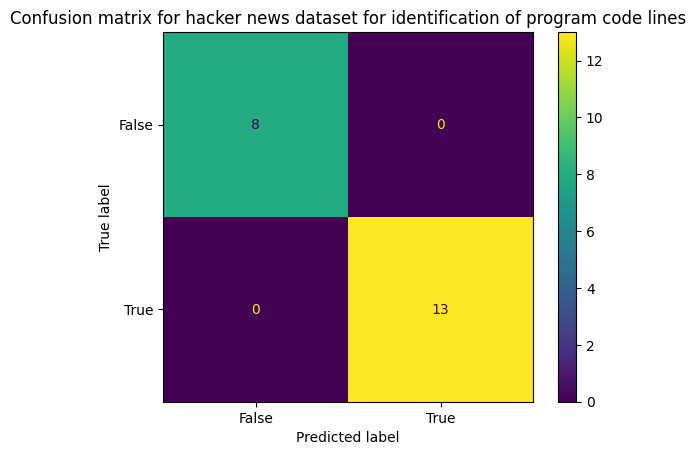

Accuracy score: 1.0


In [26]:
with open(programming_language_detector_filename, 'r') as file:
    json_data = json.load(file)
    for elem in json_data:
        # Skip issues, because all the program labels are correct and CM returns error. 
        if elem == "issues": 
            continue
        lines_data = json_data[elem]
        y_pred = [True if line_data['Language'] == ['prog', 'prog'] else False for line_data in lines_data]
        y_true = [line_data['is_program'] for line_data in lines_data]
        assert(len(y_pred) == len(y_true))
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
        disp.plot()
        plt.title(f"Confusion matrix for {elem} dataset for identification of program code lines")
        plt.show()
        print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")

In [27]:
with open(programming_language_detector_filename, 'r') as file:
    json_data = json.load(file)
    for elem in json_data:
        lines_data = json_data[elem]
        y_pred_correct = [True if any([line_data['Language'] == ['prog', 'prog'] and line_data['is_program'] == True, line_data['Language'] != ['prog', 'prog'] and line_data['is_program'] == False]) else False for line_data in lines_data]
        assert(len(lines_data) == len(y_pred_correct))
        for idx, pred in enumerate(y_pred_correct):
            if pred == False:
                line_data = lines_data[idx]
                if line_data['Language'] == ['prog', 'prog'] and line_data['is_program'] == False:
                    print(f"False-positive for line: '{line_data['Line']}', predicted program, but was not a program.")
                elif line_data['Language'] != ['prog', 'prog'] and line_data['is_program'] == True:
                    print(f"False-negative for line: '{line_data['Line']}', predicted not program, but was program.")
                else:
                    continue                

False-positive for line: 'Requirements:', predicted program, but was not a program.
False-negative for line: 'set -e', predicted not program, but was program.
False-positive for line: '## Project Specifics', predicted program, but was not a program.
False-positive for line: '## Contributing and Support', predicted program, but was not a program.
False-positive for line: '# Junior - Your AI contributor which codes itself.', predicted program, but was not a program.
False-positive for line: '- Prefer *async/await* over promises!', predicted program, but was not a program.
False-positive for line: 'Requirements:', predicted program, but was not a program.
False-positive for line: '[Commands solving the task]', predicted program, but was not a program.
False-positive for line: '- The frontend uses *Solidjs* and Tailwind, edit .jsx file accordingly!', predicted program, but was not a program.
False-positive for line: '# Output Format', predicted program, but was not a program.
False-negativ

# Data exploration

In [28]:
dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

def count_conv_len_and_word_count(dataframe):
    dataframe_conversation_lengths, dataframe_conversation_lengths_for_avg, dataframe_prompt_lengths_sum, dataframe_prompt_wordcounts_sum = [], [], [], []
    for index, df_row in dataframe.iterrows():
        conversations = df_row.Conversations
        lengths = []
        conv_length = len(conversations)
        for conv_idx in range(len(conversations)):
            conversation = conversations[conv_idx]
            prompt = conversation["Prompt"]
            prompt_len = len(prompt)
            prompt_word_count = len(prompt.split())
            if len(dataframe_conversation_lengths_for_avg) <= conv_idx:
                dataframe_conversation_lengths_for_avg.append(1)
            else:
                dataframe_conversation_lengths_for_avg[conv_idx] += 1
            if len(dataframe_prompt_lengths_sum) <= conv_idx:
                dataframe_prompt_lengths_sum.append(prompt_len)
            else:
                dataframe_prompt_lengths_sum[conv_idx] += prompt_len
            if len(dataframe_prompt_wordcounts_sum) <= conv_idx:
                dataframe_prompt_wordcounts_sum.append(prompt_word_count)
            else:
                dataframe_prompt_wordcounts_sum[conv_idx] += prompt_word_count
        dataframe_conversation_lengths.append(conv_length)
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_lengths_sum))
    avg_prompt_lengths = [dataframe_prompt_lengths_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))]
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_wordcounts_sum))
    avg_prompt_word_counts = [dataframe_prompt_wordcounts_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))]
    conversation_count_per_conv_nr = np.zeros(max(dataframe_conversation_lengths))
    conv_len_dictionary = dict()
    for i in dataframe_conversation_lengths:
        conv_len_dictionary[i] = conv_len_dictionary.get(i, 0) + 1
        conversation_count_per_conv_nr[:i] += 1
    conv_len_dictionary = dict(sorted(conv_len_dictionary.items())) # Sort
    return conversation_count_per_conv_nr, conv_len_dictionary, avg_prompt_lengths, avg_prompt_word_counts
    
conversation_count_per_conv_nr_list, avg_prompt_lengths_list, avg_prompt_word_count_list = [], [], []
for idx in range(len(dataframes)):
    conversations_per_conv_nr, conv_dictionary, avg_prompt_lens, avg_prompt_wc = count_conv_len_and_word_count(dataframes[idx])
    conversation_count_per_conv_nr_list.append(conversations_per_conv_nr)
    avg_prompt_lengths_list.append(avg_prompt_lens)
    avg_prompt_word_count_list.append(avg_prompt_wc)
    print(f"Statistics for {dataframe_names[idx]} dataframe:")
    print("Dictionary containing the count of the lengths of the conversations: ", conv_dictionary)
    print("Average prompt lengths for each prompt: ", avg_prompt_lens)
    print("Average word count for each prompt: ", avg_prompt_wc)
    print("=============================================================================")

Statistics for commits dataframe:
Dictionary containing the count of the lengths of the conversations:  {1: 509, 2: 53, 3: 34, 4: 16, 5: 5, 6: 5, 7: 6, 8: 1, 9: 5, 10: 3, 11: 3, 13: 2, 14: 2, 15: 2, 16: 2, 17: 1, 19: 2, 20: 1, 21: 1, 24: 2, 25: 1, 26: 2, 29: 1, 33: 1, 63: 1}
Average prompt lengths for each prompt:  [2696.0937972768534, 537.3618421052631, 471.3030303030303, 337.89230769230767, 320.6734693877551, 359.1363636363636, 454.2564102564103, 421.3030303030303, 466.03125, 644.6296296296297, 694.5, 580.7619047619048, 415.2857142857143, 629.5263157894736, 906.8823529411765, 136.0, 736.4615384615385, 291.3333333333333, 160.08333333333334, 95.6, 106.66666666666667, 137.875, 187.25, 167.5, 119.5, 125.4, 153.33333333333334, 47.333333333333336, 120.33333333333333, 44.5, 30.5, 29.0, 3746.0, 20.0, 39.0, 14.0, 28.0, 38.0, 12.0, 25.0, 10.0, 32.0, 32.0, 33.0, 14.0, 22.0, 21.0, 24.0, 24.0, 65.0, 62.0, 25.0, 18.0, 43.0, 169.0, 73.0, 30.0, 42.0, 139.0, 32.0, 52.0, 26.0, 51.0]
Average word count

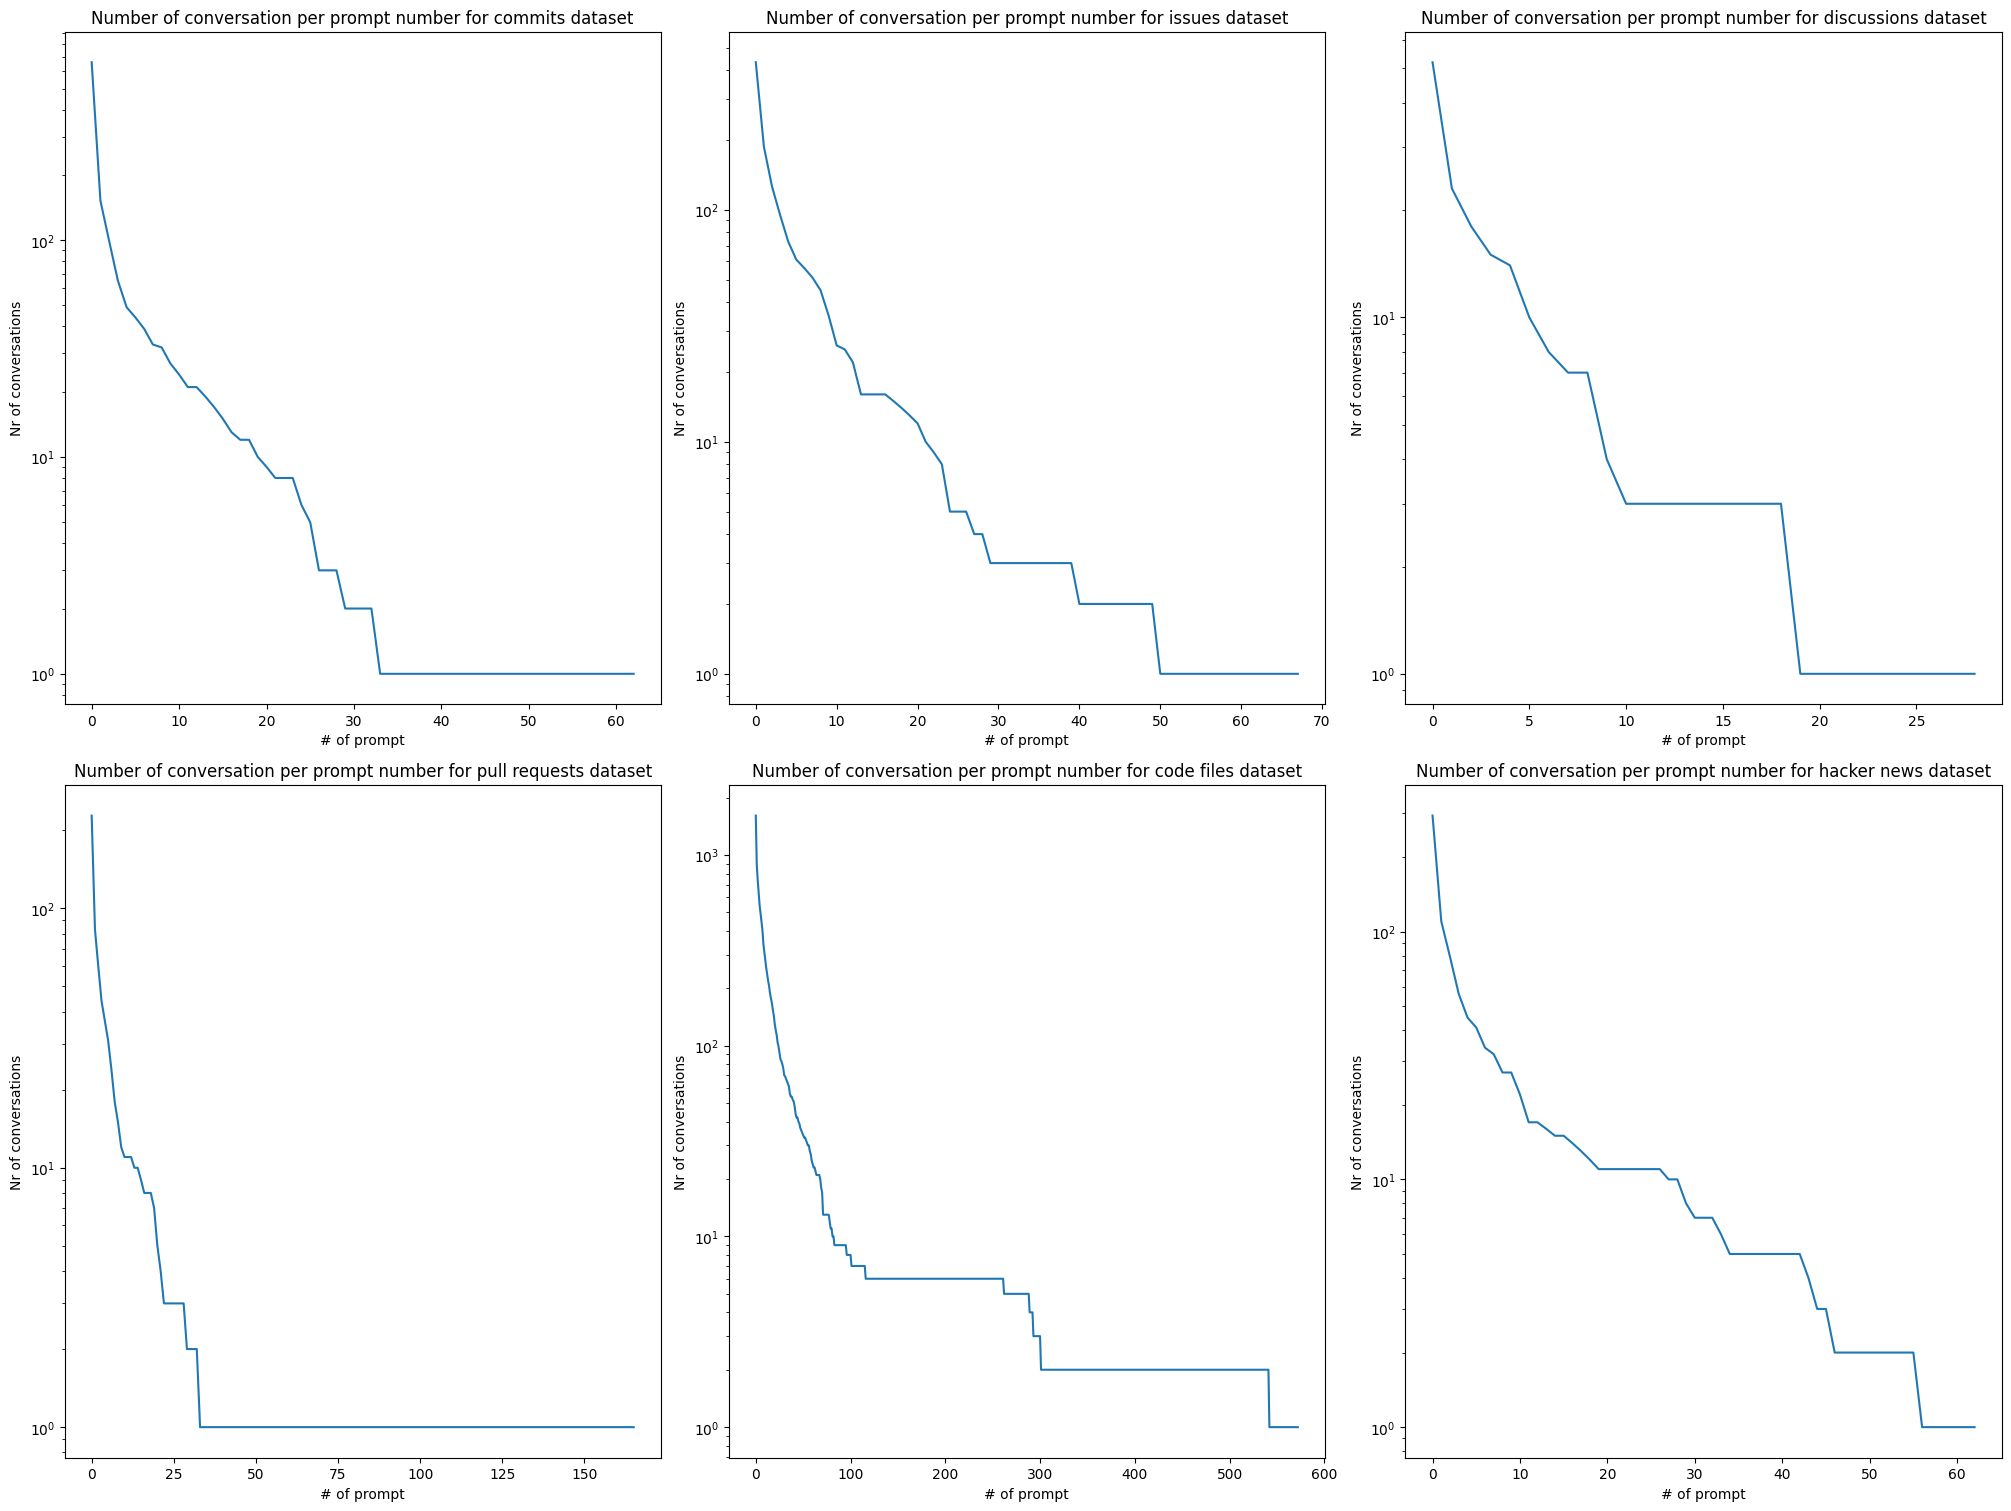

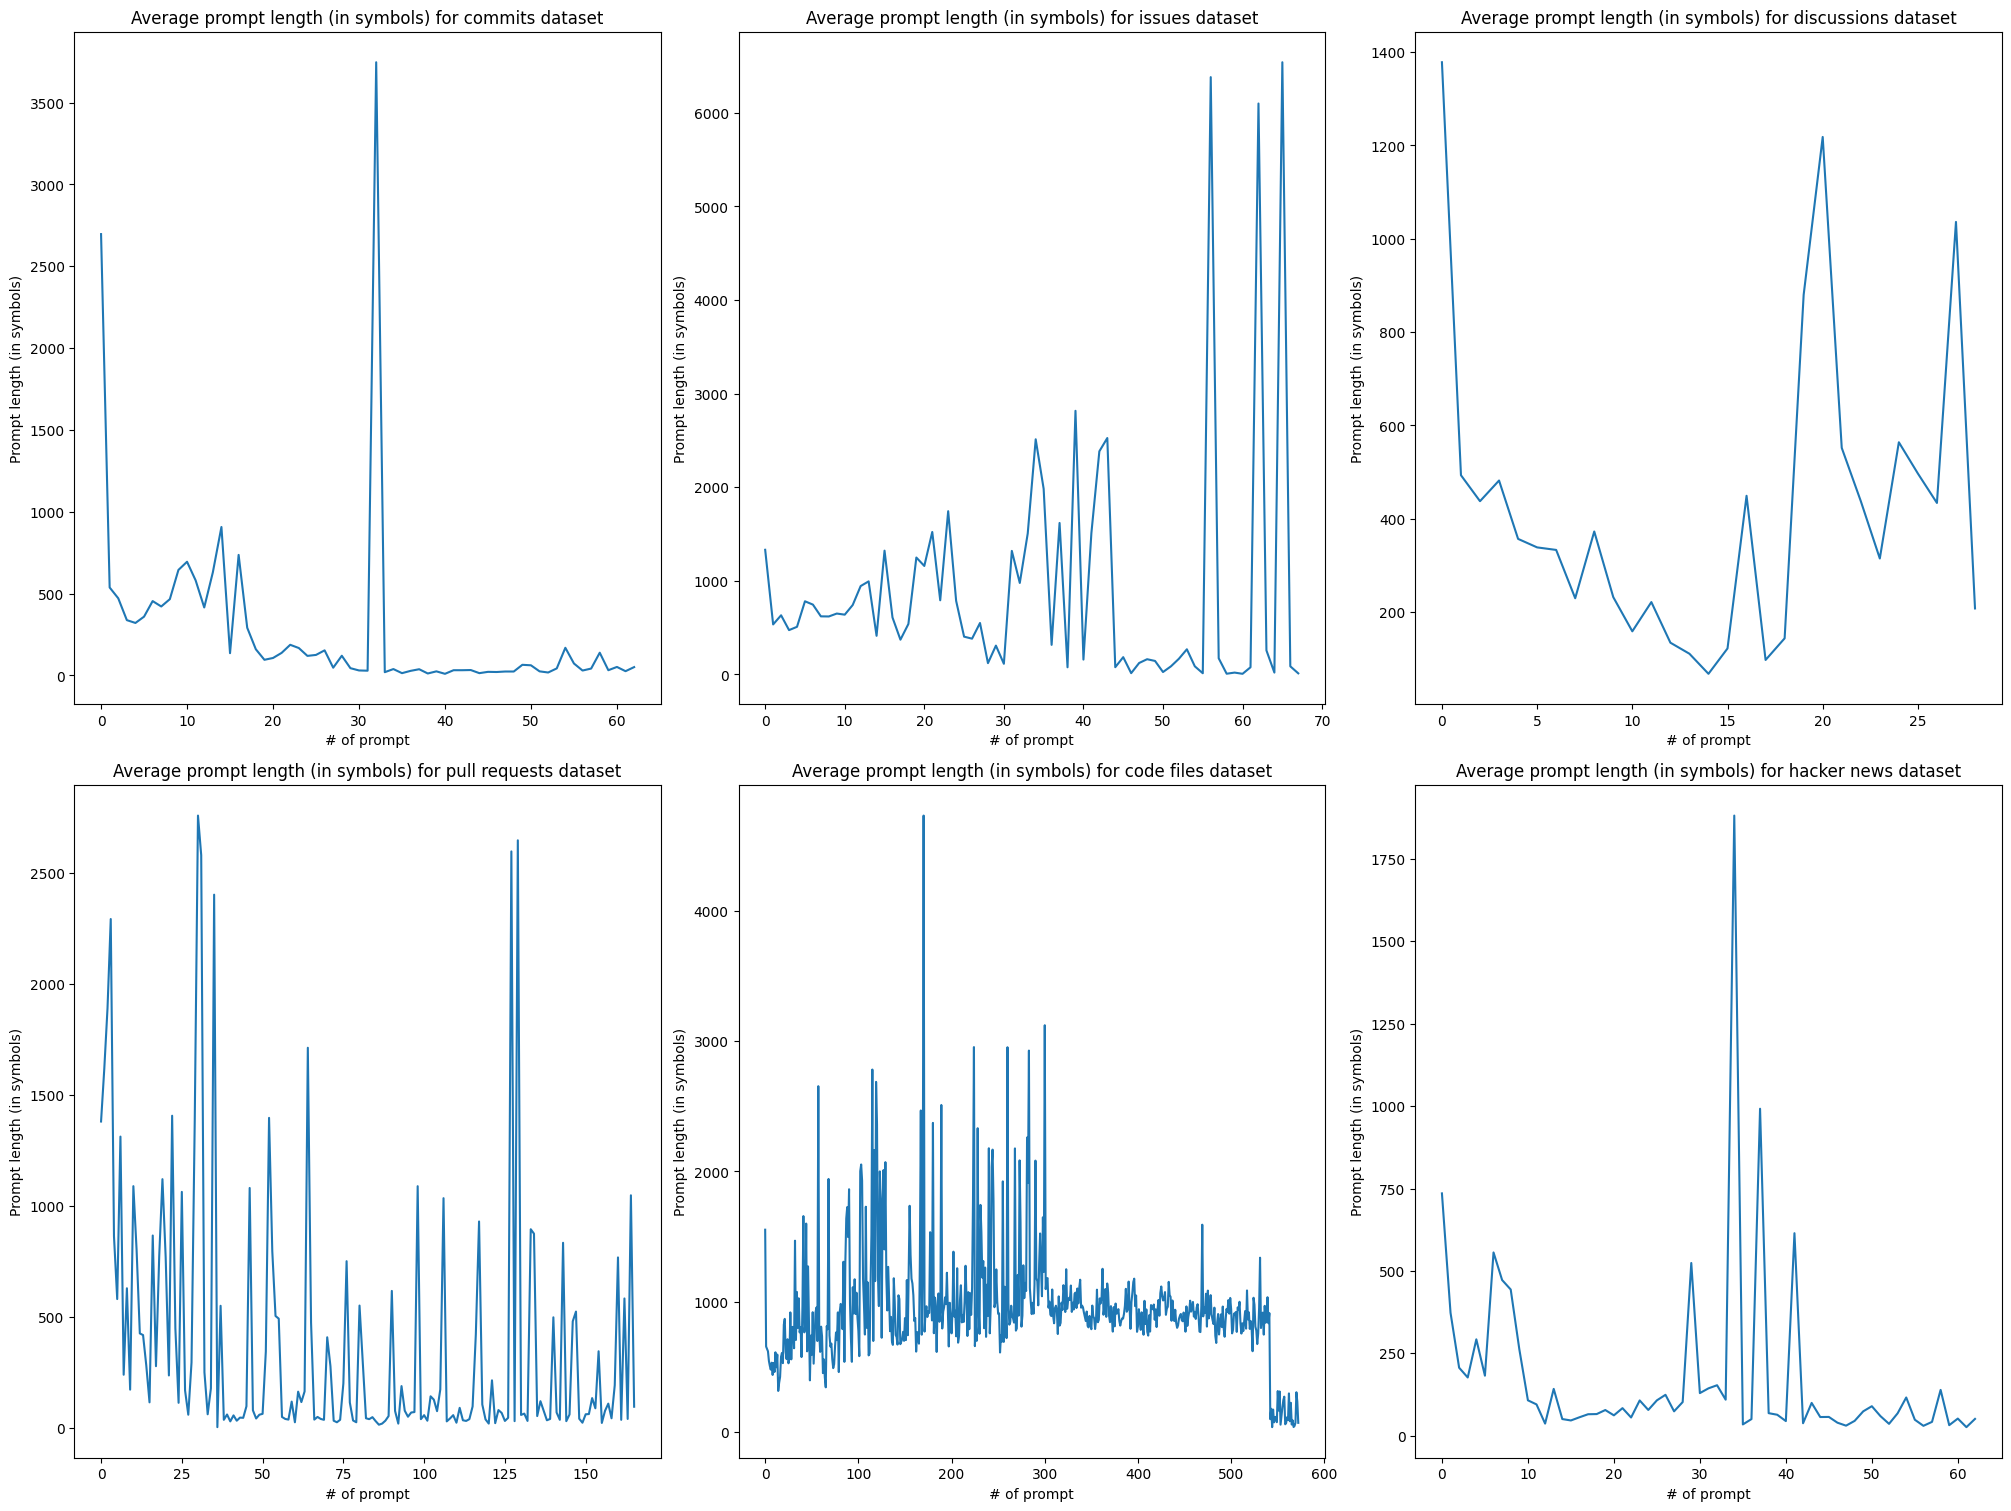

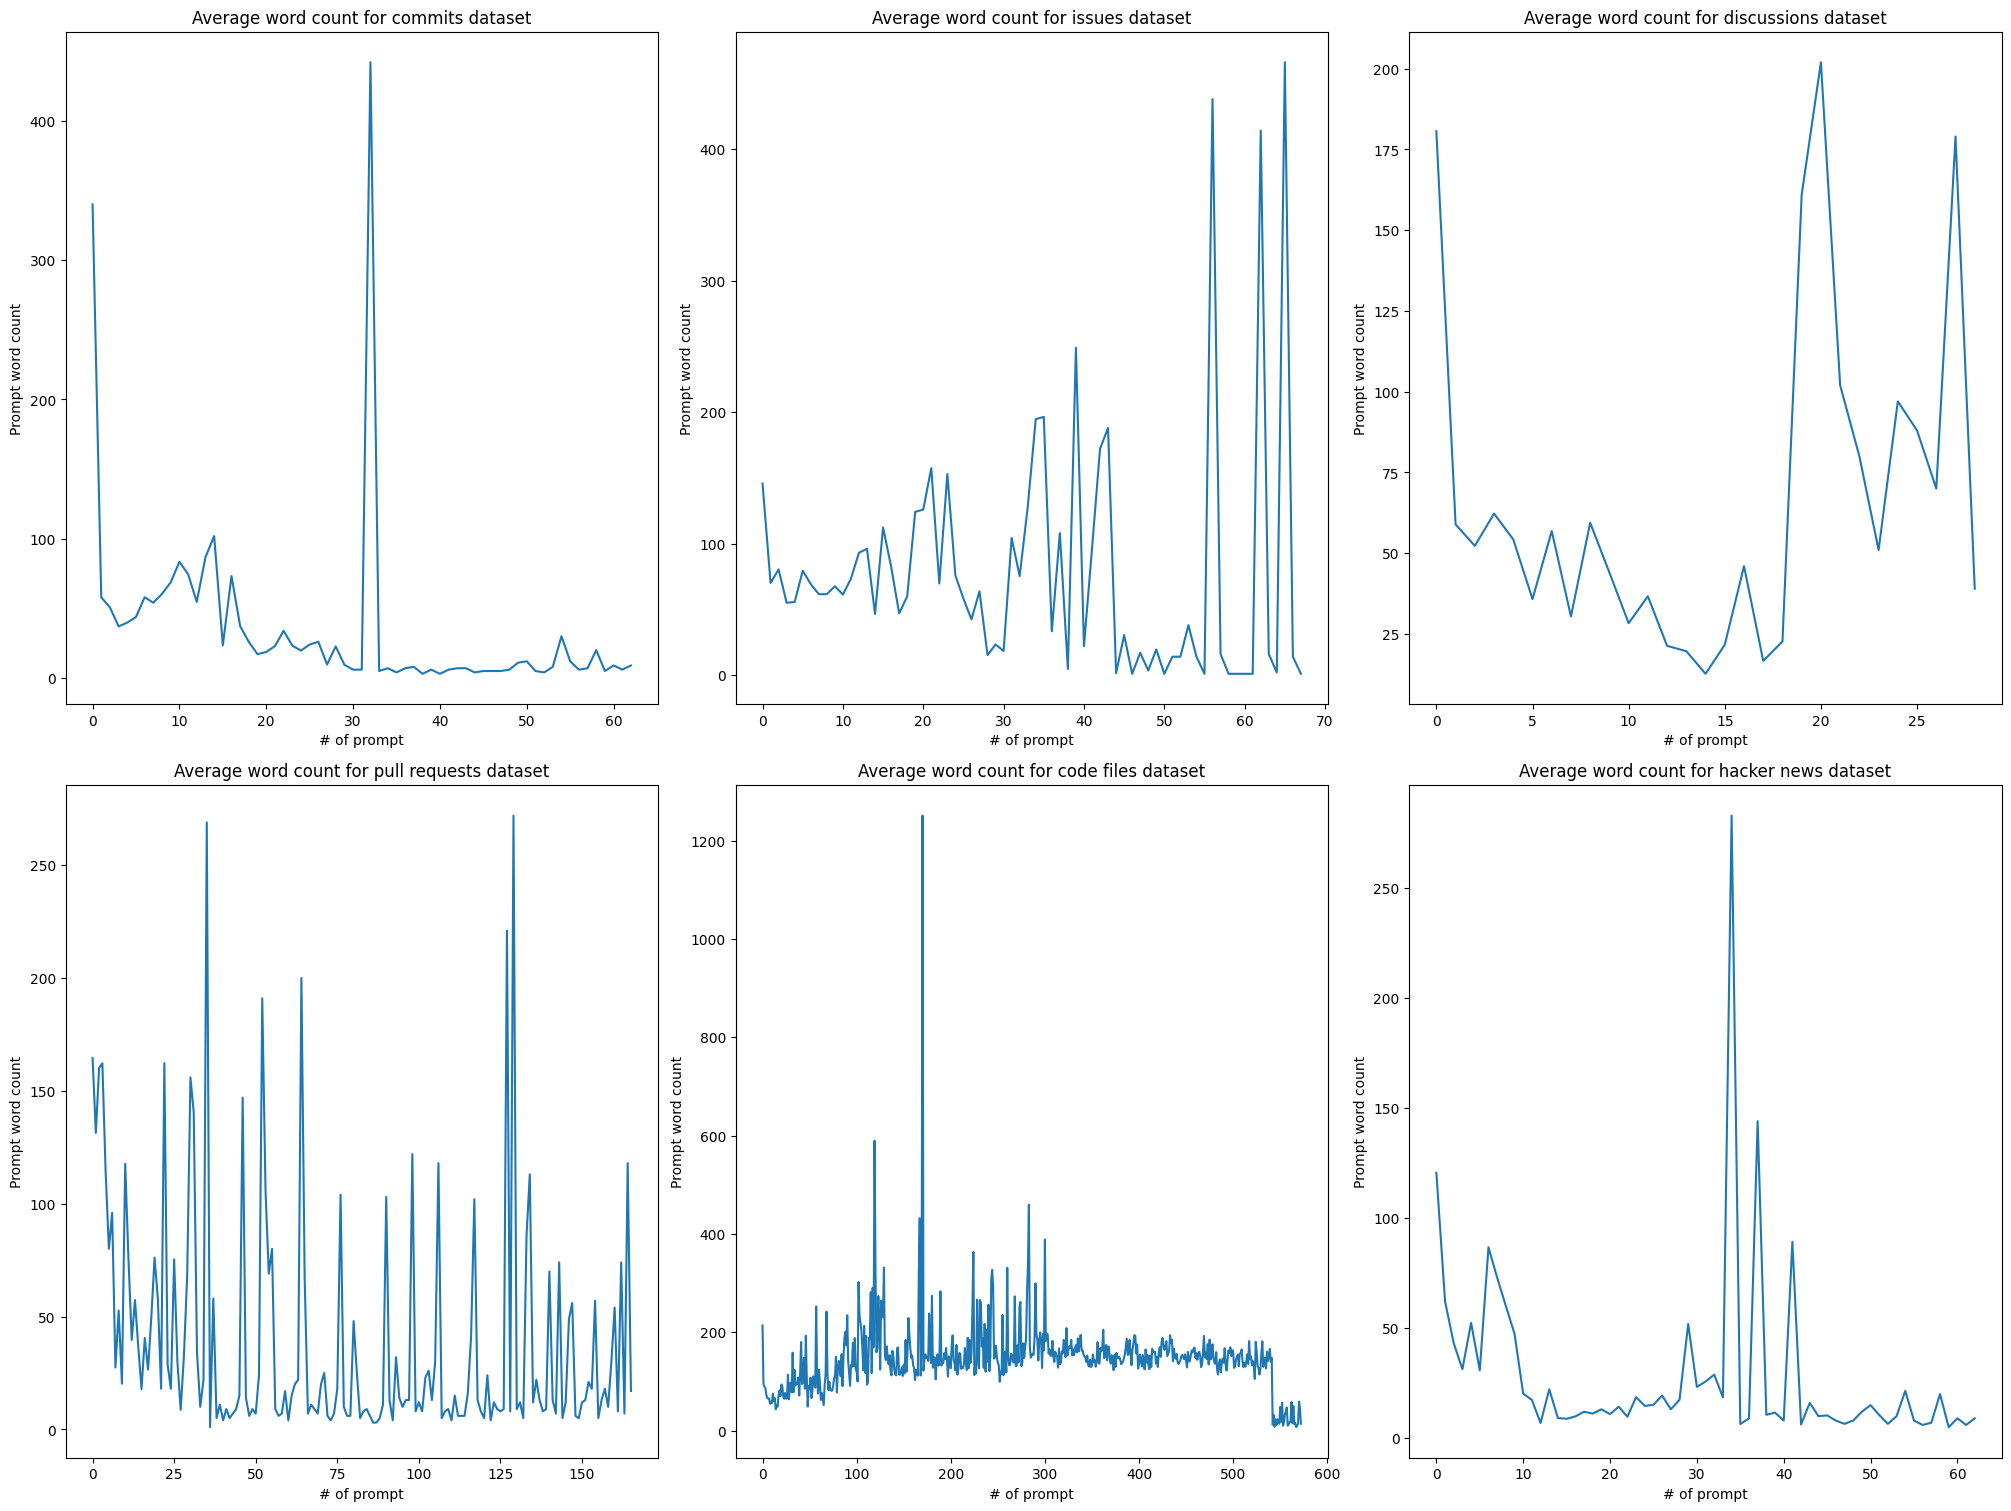

In [29]:
stats = [conversation_count_per_conv_nr_list, avg_prompt_lengths_list, avg_prompt_word_count_list]
stats_titles = ["Number of conversation per prompt number", "Average prompt length (in symbols)", "Average word count"]
stats_ylabels = ["Nr of conversations", "Prompt length (in symbols)", "Prompt word count"]

assert(len(stats) == len(stats_titles) == len(stats_ylabels))

for stat_idx, stat in enumerate(stats):
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 15), layout="constrained")
    plt.xlabel("Prompt number")
    plt.ylabel(f'{stats_ylabels[stat_idx]}')
    for idx in range(len(dataframes)):
        i,j = int(not(idx<3)),idx % 3
        if stat_idx == 0:
            axs[i,j].set_yscale("log")
        axs[i,j].set_title(f'{stats_titles[stat_idx]} for {dataframe_names[idx]} dataset')
        axs[i,j].set_xlabel(f'# of prompt')
        axs[i,j].set_ylabel(stats_ylabels[stat_idx])
        axs[i,j].plot(stat[idx])
        
    
    plt.show()

# Clean dataframes from the program code

In [30]:
dataframes_cleaned = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]

for idx, dataframe in enumerate(dataframes):
    for index, df_row in dataframe.iterrows():
        conversations = df_row["Conversations"]
        for conv in conversations:
            cleaned_lines = []
            for line in conv['Prompt'].split("\n"):
                language = detect_programming_languages(line)
                if language == ("prog", "prog"):
                    continue
                else:
                    cleaned_lines.append(line)
            conv['Prompt'] = "\n".join(cleaned_lines)

In [31]:
cleaned_dir_name = "cleaned_datasets"

if not os.path.exists(cleaned_dir_name):
    os.mkdir(cleaned_dir_name)

cleaned_dataframe_file_names = [f"{cleaned_dir_name}/cleaned_commits.json", f"{cleaned_dir_name}/cleaned_issues.json", f"{cleaned_dir_name}/cleaned_discussions.json", f"{cleaned_dir_name}/cleaned_pull_requests.json", f"{cleaned_dir_name}/cleaned_code_files.json", f"{cleaned_dir_name}/cleaned_hacker_news.json"]

for i, dataframe in enumerate(dataframes_cleaned):
    dataframe.reset_index(drop=True, inplace=True)
    jso = dataframe.to_json(orient='records')
    with open(cleaned_dataframe_file_names[i], 'w') as file:
        json.dump(json.loads(jso), file)